# Example of tuning using a tuning core file

Tuning core's are the format used by SIMCAP. SIMCAP is a MatLAB library used for running and tuning
MAGICC. To aid inter-operatability, `scmcallib` can use the same files used to drive the point estimates
in SIMCAP.

In [1]:
%matplotlib notebook

from os.path import join
import json
from logging import basicConfig

from pymagicc.io import MAGICCData
from scmcallib.scm import MAGICC7_Parallel
from scmcallib.tuningcore import read_csv_tuningcore, create_point_model

basicConfig(level='INFO')

DATA_DIR = '../tests/test_data'

<IPython.core.display.Javascript object>

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [2]:
# Lets look at the tuning core file
with open(join(DATA_DIR, 'tuningcore_example.csv')) as fh:
    lines = fh.readlines()
print(''.join(lines))

0;a;Description: ;;;;;;;;;;;;;;;;;
;;;;;;;;;;;;;;;;;;;
;;;;;;;;;;;;;;;;;;;
;;;;;;;;;;;;;;;;;;;
PARAMETERNAMES or DATCODE;shortname;middlename;longname;do_tuning;CO2_FEEDBACKFACTOR_NPP;CO2_FEEDBACKFACTOR_NPP;CO2_FEEDBACKFACTOR_NPP;CO2_FERTILIZATION_FACTOR;NCYCLE_TURNOVERTIME_LOSSES;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;CARBONCYCLE;;
SCENARIO;;;;;;;;;;RCP85_C0;RCP85_C0;RCP85_C0;RCP85_C0;RCP85_C1;RCP85_C1;RCP85_C1;RCP85_C1;RCP85_C0;RCP85_C1
ARRAYPLACE for parameters or COLCODE for tuning data;;;;;1;1;1;1;1;CURRENT_NPP;CURRENT_NPP;TOTALRESPIRATION;TOTALRESPIRATION;CURRENT_NPP;CURRENT_NPP;TOTALRESPIRATION;TOTALRESPIRATION;;
TUNINGPURPOSE;TUNECODE;TUNENAME;DESCR;do_tuning;STARTVALUE;MIN;MAX;FIXEDVALUE;FIXEDVALUE;DATSOURCE;WEIGHT;DATSOURCE;WEIGHT;DATSOURCE;WEIGHT;DATSOURCE;WEIGHT;XTRASCENSETTING;XTRASCENSETTING
DESCRIPTION;Short Name;Short Name official;Long Name ;indicate, whether you want to tune this model, assuming there is enough data.. ;;;;;

In [3]:
# First the CSV file is converted to an intermediate dict format
# This dict contains all of the information needed to create the point estimate model
tuning_core = read_csv_tuningcore(join(DATA_DIR, 'tuningcore_example.csv'))
print(json.dumps(tuning_core, indent=4))

{
    "runs": [
        {
            "code": "Cable2018",
            "name": "CableCO2calib",
            "description": "CableCO2calib",
            "do_tuning": true,
            "fixed_parameters": [
                {
                    "name": "CO2_FERTILIZATION_FACTOR",
                    "value": 1.0
                },
                {
                    "name": "NCYCLE_TURNOVERTIME_LOSSES",
                    "value": 2.0
                }
            ],
            "free_parameters": [
                {
                    "name": "CO2_FEEDBACKFACTOR_NPP",
                    "value": -0.0217,
                    "min": -0.2,
                    "max": 0.2,
                    "distribution": "uniform"
                }
            ],
            "scenarios": [
                {
                    "name": "RCP85_C0",
                    "tuning_data": [
                        {
                            "variable": "CARBONCYCLE_CURRENT_NPP",
                         

In [4]:
# Update the tuning data to something which is available locally
tuning_data = {
        "RCP85_C0": [
            {
                "variable": "CARBONCYCLE_CURRENT_NPP",
                "file_variable": "npp",
                "region": "World",
                "file": join(DATA_DIR, "CABLE_RCP85-C0_tuning.MAG"),
                "weight": 1078.0
            }
        ],
        "RCP85_C1": [
            {
                "variable": "CARBONCYCLE_CURRENT_NPP",
                "file_variable": "npp",
                "region": "World",
                "file": join(DATA_DIR, "CABLE_RCP85-C1_tuning.MAG"),
                "weight": 10.9
            }
        ]
    }

model_run = tuning_core['runs'][0]
for sce in model_run['scenarios']:
    sce['tuning_data'] = tuning_data[sce['name']]

In [5]:
# Create a new point model from each of the runs in the tuning core.
point = create_point_model(model_run)
print(point.parameter_set)

INFO:scmcallib.finder.base:iterating over [{'scenario': 'RCP85_C0'}, {'scenario': 'RCP85_C1'}] each fit


Config Parameters:
scenario                                                           RCP85_C0  \
CO2_FEEDTEMP_LANDONLY_APPLY                                               1   
CO2_FERTILIZATION_FACTOR                                                  1   
CO2_FERTILIZATION_METHOD                                                  3   
CO2_FERTILIZATION_YRSTART                                              1760   
CO2_SWITCHFROMCONC2EMIS_YEAR                                           2110   
CO2_TEMPFEEDBACK_YRSTART                                               1760   
CORE_PRESCRTEMP_APPLY                                                     1   
CORE_SWITCHFROMPRESC2TEMP_YEAR                                         2110   
FILE_CO2B_EMIS                                        HISTNULL_CO2B_EMIS.IN   
FILE_CO2_CONC                           RCP85_ENDOFYEAR_CO2_CONC_CABLEC0.IN   
FILE_EMISSCEN                                               WMO_MHALO.SCEN7   
FILE_EMISSCEN_2                  

In [6]:
# Run the model
with MAGICC7_Parallel(n_workers=4) as scm:
    res = point.find_best_fit(scm, optimiser_name="bayesopt")

INFO:scmcallib.scm.magicc:Starting process pool for magicc
INFO:scmcallib.scm.magicc:Creating new magicc instance: (7, 'ForkProcess-3') - 
INFO:scmcallib.scm.magicc:Creating new magicc instance: (7, 'ForkProcess-2') - 
INFO:scmcallib.finder.point_estimate:run_num: 0 metric_value: -34.01814159288099
INFO:scmcallib.scm.magicc:Creating new magicc instance: (7, 'ForkProcess-4') - 
INFO:scmcallib.scm.magicc:Creating new magicc instance: (7, 'ForkProcess-5') - 
INFO:scmcallib.finder.point_estimate:run_num: 1 metric_value: -46.541962287969056
INFO:scmcallib.finder.point_estimate:run_num: 2 metric_value: -804.3549641576979
INFO:scmcallib.finder.point_estimate:run_num: 3 metric_value: -130.9666604633415
INFO:scmcallib.finder.point_estimate:run_num: 4 metric_value: -31.512446933093514
INFO:scmcallib.finder.point_estimate:run_num: 5 metric_value: -65.26042256452993
INFO:scmcallib.finder.point_estimate:run_num: 6 metric_value: -19.63581121964532
INFO:scmcallib.finder.point_estimate:run_num: 7 metr

INFO:scmcallib.finder.point_estimate:run_num: 96 metric_value: -18.292762283869173
INFO:scmcallib.finder.point_estimate:run_num: 97 metric_value: -16.807909237620922
INFO:scmcallib.finder.point_estimate:run_num: 98 metric_value: -32.61041303921025
INFO:scmcallib.finder.point_estimate:run_num: 99 metric_value: -708.374160359222
INFO:scmcallib.finder.point_estimate:run_num: 100 metric_value: -16.646005923856702
INFO:scmcallib.finder.point_estimate:run_num: 101 metric_value: -16.931380252166676
INFO:scmcallib.finder.point_estimate:run_num: 102 metric_value: -16.686708792836107
INFO:scmcallib.finder.point_estimate:run_num: 103 metric_value: -16.64599845969714
INFO:scmcallib.finder.point_estimate:run_num: 104 metric_value: -16.649582204711677
INFO:scmcallib.finder.point_estimate:run_num: 105 metric_value: -16.64787138250928
INFO:scmcallib.finder.point_estimate:run_num: 106 metric_value: -17.055086909181664
INFO:scmcallib.finder.point_estimate:run_num: 107 metric_value: -16.658994918928638
I

In [7]:
res.target

variable   CARBONCYCLE_CURRENT_NPP           
region                       World           
scenario                  RCP85_C0   RCP85_C1
time                                         
1901-01-01                5.203655 -34.593018
1902-01-01                5.709455 -33.941018
1903-01-01                6.433655 -33.048818
1904-01-01                5.471655 -33.805218
1905-01-01                5.749455 -33.287518
1906-01-01                6.975555 -31.823418
1907-01-01                6.126255 -32.452218
1908-01-01                6.762355 -31.562818
1909-01-01                6.997855 -31.088718
1910-01-01                6.332055 -31.515418
1911-01-01                5.915655 -31.710718
1912-01-01                5.642355 -31.751718
1913-01-01                4.952055 -32.195218
1914-01-01                5.200955 -31.687118
1915-01-01                5.522355 -31.034718
1916-01-01                6.213555 -30.070318
1917-01-01                5.544455 -30.526718
1918-01-01                4.697955 -31.174618
1919-01-01                5.411955 -30.172718
1920-01-01                5.349155 -29.945518
1921-01-01                5.656455 -29.388918
1922-01-01                5.821555 -28.861518
1923-01-01                5.147155 -29.292118
1924-01-01                5.267355 -28.794518
1925-01-01                4.181155 -29.593018
1926-01-01                5.675455 -27.609918
1927-01-01                4.995255 -28.052518
1928-01-01                5.407955 -27.322618
1929-01-01                4.485555 -27.930218
1930-01-01                4.422955 -27.780418
...                            ...        ...
2071-01-01              -12.904745  39.545282
2072-01-01              -11.900545  42.348282
2073-01-01              -12.611145  41.570282
2074-01-01              -13.027045  42.431282
2075-01-01              -12.032045  45.695282
2076-01-01              -13.641745  42.262282
2077-01-01              -13.429645  44.327282
2078-01-01              -12.741545  45.546282
2079-01-01              -13.868245  44.724282
2080-01-01              -13.526845  46.636282
2081-01-01              -14.177245  45.916282
2082-01-01              -14.233645  47.603282
2083-01-01              -15.467945  45.225282
2084-01-01              -15.457945  47.323282
2085-01-01              -15.062645  48.960282
2086-01-01              -15.071945  48.824282
2087-01-01              -16.489145  45.771282
2088-01-01              -15.741745  48.266282
2089-01-01              -16.873045  46.636282
2090-01-01              -16.931745  46.991282
2091-01-01              -17.798745  45.479282
2092-01-01              -17.566545  47.143282
2093-01-01              -16.709345  50.262282
2094-01-01              -16.957545  50.866282
2095-01-01              -18.380745  48.496282
2096-01-01              -17.574445  50.453282
2097-01-01              -17.355445  52.000282
2098-01-01              -17.950545  49.718282
2099-01-01              -19.256245  47.385282
2100-01-01              -19.006945  49.020282

[200 rows x 2 columns]

<IPython.core.display.Javascript object>


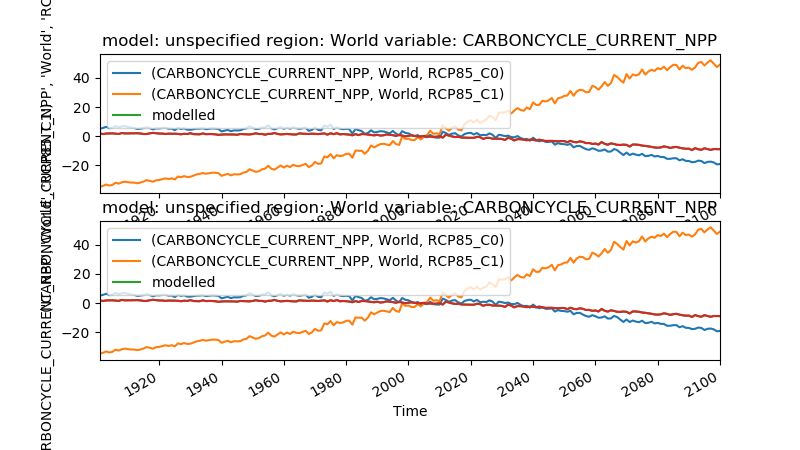

(<Figure size 800x450 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0dc5a128>,
       dtype=object))

In [8]:
res.plot_fit()

In [9]:
res.coeffs

{'CO2_FEEDBACKFACTOR_NPP': -0.07786763956366971}

<IPython.core.display.Javascript object>


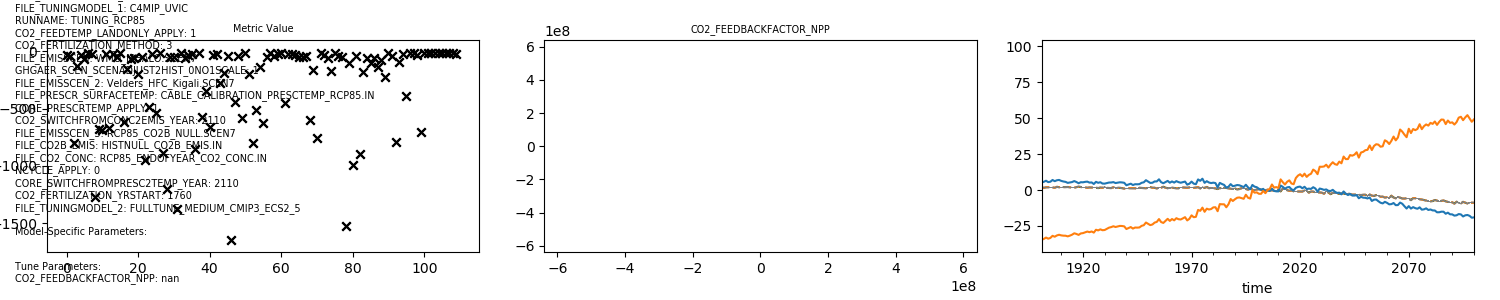


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [10]:
res.plot_summary()